# Лабораторная работа по вычислительной математике 3(6)

**Цель работы:** Изучение численных методик решения параболических уравнений, в частности, уравнения теплопроводности

## Дифференциальная задача:

$$\frac{\partial{U}}{\partial{t}} = \frac{\partial{}}{\partial{x}}(U^{3/2}\frac{\partial{U}}{\partial{x}}) + \frac{\partial{}}{\partial{y}}(U^{3/2}\frac{\partial{U}}{\partial{y}})$$
$$U(0, x, y) = \frac{(1 + x + y)^{4/3}}{100^{1/3}}$$
$$U(t, 0, y) = \frac{(1 + y)^{4/3}}{(10 - 28t/3)^{2/3}}$$
$$U(t, 1, y) = \frac{(2 + y)^{4/3}}{(10 - 28t/3)^{2/3}}$$
$$U(t, x, 0) = \frac{(1 + x)^{4/3}}{(10 - 28t/3)^{2/3}}$$
$$U(t, x, 1) = \frac{(2 + x)^{4/3}}{(10 - 28t/3)^{2/3}}$$

Её аналитическим решением является следующее выражение:
$$U(t, x, y) = \frac{(1 + x + y)^{4/3}}{(10 - 28t/3)^{2/3}}$$

## Схема Яненко

$$\frac{\hat{U}^{n}_{l,m} - U^n_{l,m}}{\tau} = \frac{1}{h_x}(k_{l+1/2,m}(\frac{\hat{U}^{n}_{l+1,m} - \hat{U}^n_{l,m}}{h_x}) - k_{l-1/2, m}(\frac{\hat{U}^{n}_{l,m} - \hat{U}^{n}_{l-1,m}}{h_x}))$$
$$\frac{U^{n+1}_{l,m} - \hat{U}^n_{l,m}}{\tau} = \frac{1}{h_y}(k_{l,m+1/2}(\frac{U^{n+1}_{l,m+1} - U^{n+1}_{l,m}}{h_y}) - k_{l, m-1/2}(\frac{U^{n+1}_{l,m} - U^{n+1}_{l,m-1}}{h_y}))$$

## Код

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tabulate

In [19]:
def analit_sol(x, y, t):
    divided = (1 + x + y)**(4/3)
    divisor = (10 - 28*t/3)**(2/3)
    return divided/divisor


def error_calculator(u1, u2):
    dif = u1 - u2
    error = max([dif.max(), abs(dif.min())])
    return error


# The (2d+time)-grid generation
def get_grid(l, m, n):
    grid = []
    for i in range(n + 1):
        time_slice = []
        for j in range(l + 1):
            line = []
            for k in range(m + 1):
                point = (j / l, k / m, i / n)  # (x,y,t)
                line.append(point)
            time_slice.append(line)
        grid.append(time_slice)
    return np.array(grid)


def init_u(l, m, n, limit_conditions, limit_place_func, grid):
    u = []
    for i in range(n + 1):
        time_slice = []
        for j in range(l + 1):
            line = [0] * (m + 1)
            for k in range(m + 1):
                for ind, place_func in enumerate(limit_place_func):
                    if place_func(*grid[i, j, k]):
                        line[k] = limit_conditions[ind](*grid[i, j, k])
            time_slice.append(line)
        u.append(time_slice)
    return np.array(u, dtype=np.float64)


def Thomas_solve(n, a, b, c, f):
    # Special case
    if n == 1:
        return f[0]/a[0]
    # b will contain alpha, f will contain beta
    # We also believe, that the input is such that we do not need to concern ourselves
    # With division by zero

    if n > 1:
        # Forward sweep
        for i in range(n - 1):
            # alpha_i
            if i == 0:
                b[i] = b[i] / a[i]
            else:
                b[i] = b[i] / (a[i] - c[i - 1] * b[i - 1])

            # beta_i
            if i == 0:
                f[i] = f[i] / a[i]
            else:
                f[i] = (f[i] - f[i - 1] * c[i - 1]) / (a[i] - c[i - 1] * b[i - 1])
        f[-1] = (f[-1] - c[-1] * f[-2]) / (a[-1] - c[-1] * b[-1])

        u = [0] * n
        # Backwards sweep
        for i in range(n - 1, -1, -1):
            if i == n - 1:
                u[i] = f[i]
            else:
                u[i] = f[i] - b[i] * u[i + 1]

        # Output
        return np.array(u)


def u_process(l, m, n, k_function, compute_abcf, limit_conditions, limit_place_func, compute_timeslice,
              tolerance=1e-6):
    grid = get_grid(l, m, n)
    u = init_u(l, m, n, limit_conditions, limit_place_func, grid)
    h_x = 1 / l
    h_y = 1 / m
    tau = 1 / n

    for t in range(1, n + 1):
        if t%10 == 0:
            print(f"progress: {t}/{n}")
        u[t] = compute_timeslice(t, h_x, h_y, tau, u, grid, k_function, compute_abcf, tolerance=tolerance)

    return u


def get_analit_on_grid(l, m, n):
    grid = get_grid(l, m, n)
    u = []
    for i in range(n + 1):
        time_slice = []
        for j in range(l + 1):
            line = []
            for k in range(m + 1):
                line.append(analit_sol(*grid[i, j, k]))
            time_slice.append(line)
        u.append(time_slice)
    return np.array(u)


#there is a kostil with absolute values
def k_function(l, m, timeslice, halfstep_l, halfstep_m):
    if not halfstep_l and not halfstep_m:
        value = (max(0, timeslice[l, m])) ** 1.5
        if np.isnan(value):
            value = 0
    else:  # Needs work
        value = ((max(0, timeslice[l, m])) ** 1.5 + max(0, timeslice[min(l+halfstep_l, len(timeslice)-1), min(m+halfstep_m, len(timeslice[0]) - 1)])**1.5)/2
    return value


# free_ind_place is either 1 or 2 - which of the indeces of k to vary
def compute_abcf(locked_ind, free_ind_place, h, tau, timeslice, prev_timeslice, k_function):
    if free_ind_place == 1:
        size = len(timeslice)
        time_space_slice_vector = timeslice[:, locked_ind]
        prev_time_space_slice_vector = prev_timeslice[:, locked_ind]

        def k(ind, halfstep):
            return k_function(ind, locked_ind, timeslice, halfstep, 0)
    elif free_ind_place == 2:
        size = len(timeslice[0])
        time_space_slice_vector = timeslice[locked_ind, :]
        prev_time_space_slice_vector = prev_timeslice[locked_ind, :]
        def k(ind, halfstep):
            return k_function(locked_ind, ind, timeslice, 0, halfstep)
    #plus one deals with the limit conditions
    def a(ind):
        return (1 / tau + 1 / h ** 2 * (k(ind + 1, 1) + k(ind + 1, -1)))
    def b(ind):
        return -1 / h ** 2 * k(ind + 1, 1)
    def c(ind):
        return -1 / h ** 2 * k(ind + 1, -1)
    def f(ind):
        value = (1 / tau) * prev_time_space_slice_vector[ind + 1]
        if ind == 0:
            value += k(ind+1, -1)/h**2 * time_space_slice_vector[0]
        elif ind == size - 3:
            value += k(ind+1, 1)/h**2 * time_space_slice_vector[-1]
        return value


    a = np.array([a(ind) for ind in range(size - 2)])
    b = np.array([b(ind) for ind in range(size - 3)])
    c = np.array([c(ind) for ind in range(1, size - 2)])
    f = np.array([f(ind) for ind in range(size - 2)])
    return a, b, c, f

def add_limits(locked_ind, free_ind, timeslice, vector):
    new_vector = None
    if free_ind == 2:
        new_vector = np.array([timeslice[locked_ind, 0]] + list(vector) + [timeslice[locked_ind, -1]])
    elif free_ind == 1:
        new_vector = np.array([timeslice[0, locked_ind]] + list(vector) + [timeslice[-1, locked_ind]])
    return new_vector

def compute_timeslice(t, h_x, h_y, tau, u, grid, k_function, compute_abcf, tolerance=1e-8):
    prev_u_slice = u[t - 1]
    curr_u_slice = u[t]
    l = len(curr_u_slice)
    m = len(curr_u_slice[0])
    error = float('inf')
    prev_approximation = np.ndarray((m, l))
    next_approximation = np.ndarray((m, l))

    # Calculating the u with a hat
    # Inititalizing
    prev_approximation[0], prev_approximation[-1] = curr_u_slice[:,0], curr_u_slice[:,-1]
    next_approximation[0], next_approximation[-1] = curr_u_slice[:,0], curr_u_slice[:,-1]
    for i in range(1, m - 1):
        a, b, c, f = compute_abcf(i, 1, h_x, tau, curr_u_slice, prev_u_slice, k_function)
        prev_approximation[i] = add_limits(i, 1, curr_u_slice, Thomas_solve(len(a), a, b, c, f))

    while error >= tolerance:
        for i in range(1, m-1):
            a, b, c, f = compute_abcf(i, 1, h_x, tau, prev_approximation.T, prev_u_slice, k_function)
            next_approximation[i] = add_limits(i, 1, prev_approximation.T, Thomas_solve(len(a), a, b, c, f))
        error = error_calculator(prev_approximation, next_approximation)
        prev_approximation[:,:] = next_approximation[:,:]

    prom_u_slice = next_approximation.T

    # Calculating the u
    # Inititalizing

    error = float('inf')
    prev_approximation = np.ndarray((l, m))
    next_approximation = np.ndarray((l, m))

    prev_approximation[0], prev_approximation[-1] = curr_u_slice[0], curr_u_slice[-1]
    next_approximation[0], next_approximation[-1] = curr_u_slice[0], curr_u_slice[-1]
    for i in range(1, l - 1):
        a, b, c, f = compute_abcf(i, 2, h_y, tau, prom_u_slice, prom_u_slice, k_function)
        prev_approximation[i] = add_limits(i, 2, prom_u_slice, Thomas_solve(len(a), a, b, c, f))

    while error >= tolerance:
        for i in range(1, l - 1):
            a, b, c, f = compute_abcf(i, 2, h_y, tau, prev_approximation, prom_u_slice, k_function)
            next_approximation[i] = add_limits(i, 2, prev_approximation, Thomas_solve(len(a), a, b, c, f))
        error = error_calculator(prev_approximation, next_approximation)
        prev_approximation[:,:] = next_approximation[:,:]

    curr_u_slice = next_approximation

    return curr_u_slice

In [20]:
def start_condition(x, y, t):
    return (1 + x + y) ** (4 / 3) / (100) ** (1 / 3)


def left_condition(x, y, t):
    return (1 + y) ** (4 / 3) / (10 - 28 * t / 3) ** (2 / 3)


def right_condition(x, y, t):
    return (2 + y) ** (4 / 3) / (10 - 28 * t / 3) ** (2 / 3)


def top_condition(x, y, t):
    return (2 + x) ** (4 / 3) / (10 - 28 * t / 3) ** (2 / 3)


def bottom_condition(x, y, t):
    return (1 + x) ** (4 / 3) / (10 - 28 * t / 3) ** (2 / 3)


def my_top_condition(x, y, t):
    return (4*x**2 - 4*x + 2)*(np.sin(40*np.pi*t) + 1)

def my_bottom_condition(x, y, t):
    return (4*x**2 - 4*x + 2)*(np.sin(40*np.pi*t) + 1)

def my_left_condition(x, y, t):
    return (4*y**2 - 4*y + 2)*(np.sin(40*np.pi*t) + 1)

def my_right_condition(x, y, t):
    return (4*y**2 - 4*y + 2)*(np.sin(40*np.pi*t) + 1)

def my_start_condition(x, y, t):
    return (4*x**2 - 4*x + 1) + (4*y**2 - 4*y + 1)


def start_place(x, y, t):
    return t == 0


def left_place(x, y, t):
    return x == 0


def right_place(x, y, t):
    return x == 1


def top_place(x, y, t):
    return y == 1


def bottom_place(x, y, t):
    return y == 0

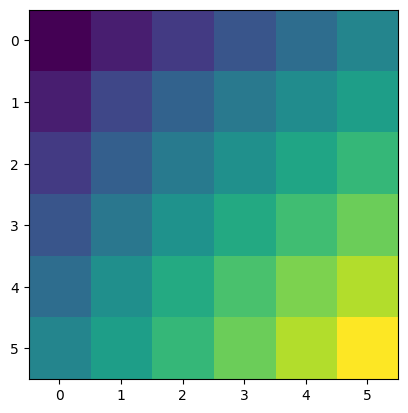

--------  --------  --------  --------  --------  --------
0.215443  0.274731  0.33742   0.403175  0.471733  0.542884
0.274731  0.33742   0.403175  0.471733  0.542884  0.616449
0.33742   0.403175  0.471733  0.542884  0.616449  0.69228
0.403175  0.471733  0.542884  0.616449  0.69228   0.770249
0.471733  0.542884  0.616449  0.69228   0.770249  0.850245
0.542884  0.616449  0.69228   0.770249  0.850245  0.93217
--------  --------  --------  --------  --------  --------
--------  --------  --------  --------  --------  --------
0.24726   0.315304  0.38725   0.462716  0.541399  0.623057
0.315304  0.398845  0.478172  0.556538  0.633507  0.707486
0.38725   0.474156  0.556646  0.637804  0.717499  0.794516
0.462716  0.555349  0.641462  0.724939  0.806104  0.884
0.541399  0.640993  0.730996  0.81648   0.898321  0.975809
0.623057  0.707486  0.794516  0.884     0.975809  1.06983
--------  --------  --------  --------  --------  --------
--------  --------  --------  --------  --------  --------
0.2

In [22]:
limit_conditions = [start_condition, left_condition, right_condition, top_condition, bottom_condition]
limit_place_functions = [start_place, left_place, right_place, top_place, bottom_place]

l, m, n = 5, 5, 5

computed_u = u_process(l, m, n, k_function, compute_abcf, limit_conditions,
                       limit_place_functions, compute_timeslice, tolerance=1e-6)

plt.imshow(computed_u[4])
plt.show()

for slice in computed_u:
    print(tabulate.tabulate(slice))